In [75]:
import numpy as np
import rasterio
import geopandas as gpd
from rasterio.enums import Resampling
from rasterio.transform import from_origin, Affine
from rasterio.mask import mask
import geopandas as gpd
from scipy.interpolate import griddata
from osgeo import gdal, gdalconst
import xdem
import matplotlib.pyplot as plt

### 1. Loading and inspecting raster data with rasterio

In [6]:
#load with rasterio
with rasterio.open('./data/DEMs/Silvretta-2020-2m.tif') as dem_src:
    dem2020 = dem_src.read(1)

In [7]:
# Explore metadata
# What is the file resolution and what is the coordinate system?
dem_src.meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': -3.4028234663852886e+38,
 'width': 4623,
 'height': 3312,
 'count': 1,
 'crs': CRS.from_epsg(2056),
 'transform': Affine(2.0, 0.0, 2797549.5,
        0.0, -2.0, 1195031.0)}

In [8]:
dem_src.bounds

BoundingBox(left=2797549.5, bottom=1188407.0, right=2806795.5, top=1195031.0)

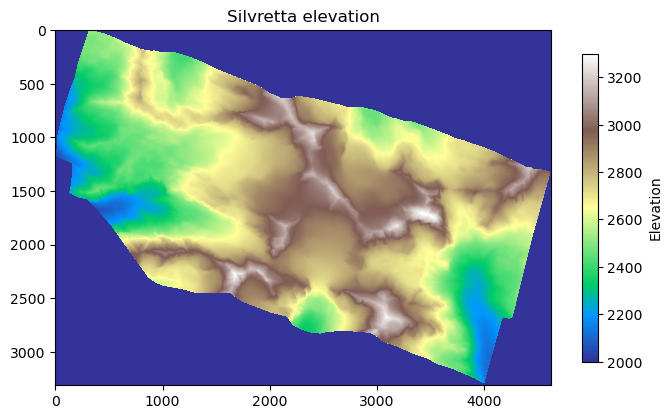

In [9]:
# Plot elevation
f, ax = plt.subplots(figsize=(8,8))
cax = ax.imshow(dem2020,
           vmin=2000, 
           vmax=3300, 
           cmap='terrain')
cbar = f.colorbar(cax, ax=ax, label='Elevation', shrink=0.5)
ax.set_title('Silvretta elevation')
plt.show()

In [10]:
# Plot elevation
# Get the bounds of the raster (leave this for participants to figure out, i.e. how to set this exactly).
bounds = dem_src.bounds
extent = [bounds.left, bounds.right, bounds.bottom, bounds.top]

In [11]:
#mask no-data values for prettyness:
if dem_src.nodata is not None:
    dem2020 = np.ma.masked_equal(dem2020, dem_src.nodata)

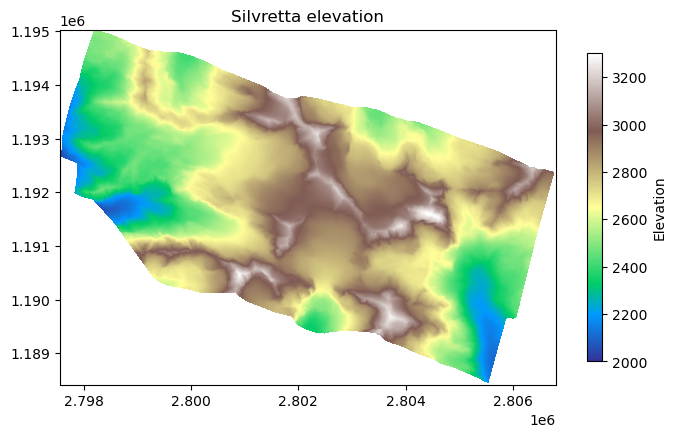

In [12]:
f, ax = plt.subplots(figsize=(8,8))
cax = ax.imshow(dem2020,
           extent=extent,
           vmin=2000, 
           vmax=3300, 
           cmap='terrain')
cbar = f.colorbar(cax, ax=ax, label='Elevation', shrink=0.5)
ax.set_title('Silvretta elevation')
plt.show()

### 2. Loading, reprojecting, and manipulating raster data with xdem


In [13]:
dem = xdem.DEM('./data/DEMs/Silvretta-2020-2m.tif')

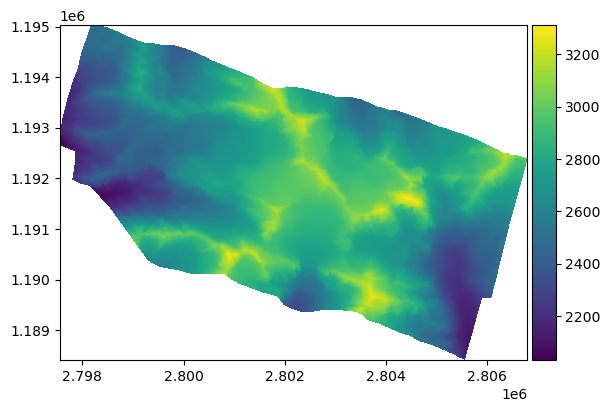

In [14]:
dem.plot() #notice how it already knows where it is in the world

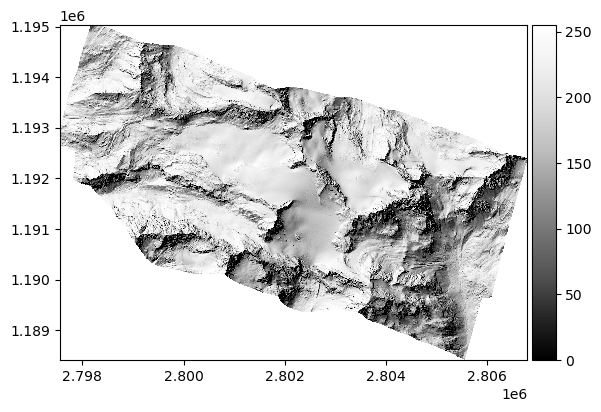

In [15]:
xdem.terrain.hillshade(dem).plot(cmap='Greys_r')

In [16]:
hillshade = xdem.terrain.hillshade(dem) #rendering on the fly is slow, let's save to a variable

In [17]:
rgi_thickness = xdem.DEM('./data/RGI60-11/RGI60-11.00804_thickness.tif')

Problem: ice thickness and our points are in different coordinate systems. We know how to reproject vector data,
so let's reproject the raster dataset instead.

In [134]:
# with xdem, reprojection is easy! 
thickness_lv95 = rgi_thickness.reproject(dem)

In [18]:
# load our outline 
outline = gpd.read_file('./data/silvretta_outline.geojson')

In [ ]:
f, ax = plt.subplots()
hillshade.plot(ax=ax,
               cmap='Greys_r',
               add_cbar=False,
               alpha=1.0)

thickness_lv95.plot(ax=ax, 
              cmap='viridis', 
              alpha=0.6)
outline.plot(ax=ax, facecolor='none', edgecolor='orange')
ax.set_xlim([outline.bounds.minx[0], outline.bounds.maxx[0]])
ax.set_ylim([outline.bounds.miny[0], outline.bounds.maxy[0]])

In [ ]:
# loading a second DEM and differencing them

In [ ]:
dem2014 = xdem.DEM('./data/DEMs/2014_SILVRETTA_DSM_1m_LV95_LN02_CIR_low_raw.tif')

In [ ]:
dem2014_reproj = dem2014.reproject(dem)

In [ ]:
diff = dem2014_reproj-dem

In [ ]:
f, ax = plt.subplots()
diff.plot(ax=ax, cmap='bwr', vmin=-10, vmax=10)
sgi.plot(ax=ax, facecolor='none')
ax.set_xlim([2795000, 2811000])
ax.set_ylim([1186250, 1195000])

In [ ]:
sgi = gpd.read_file('data/sgi_2016/SGI_2016_glaciers.shp')

### 3. Extracting data from rasters: points, polygons, multi-polygons

In [66]:
# sampling a raster dataset at predefined points or extracting information inside a 
# load geojson
sampling_points = gpd.read_file('./data/sampling_points.geojson')

In [8]:
thickness_rio = thickness_lv95.to_rio_dataset()

In [9]:
thickness_rio.nodata

-99999.0

In [10]:
masked_data, masked_transform = mask(thickness_rio, outline.geometry, crop=True, nodata=thickness_rio.nodata)

In [11]:
# Exclude NaN values from the masked array
masked_data = np.ma.masked_equal(masked_data, thickness_rio.nodata)

In [13]:
stats = {
    'min': masked_data.min(),
    'max': masked_data.max(),
    'mean': masked_data.mean(),
    'median': np.ma.median(masked_data),
    'std': masked_data.std()
}

print("Zonal Statistics:")
for key, value in stats.items():
    print(f"{key}: {value}")

Zonal Statistics:
min: 0.0
max: 153.71749877929688
mean: 77.89014095920692
median: 79.30809783935547
std: 24.415327814558005


In [ ]:
# Can you calculate the volume of ice inside the outline?

In [67]:
# Create a list to store raster values at points
raster_values_at_points = []

# Sample raster at each point
for index, point in sampling_points.iterrows():
    # Convert point coordinates to pixel coordinates
    pixel_coords = rasterio.transform.rowcol(thickness_rio.transform, point.geometry.x, point.geometry.y)

    # Get raster value at the pixel coordinate
    value = thickness_rio.read(1)[pixel_coords]

    # Add value to the list
    raster_values_at_points.append(value)

# Add raster values to GeoDataFrame
sampling_points['ice_thickness'] = raster_values_at_points

print(sampling_points)

   Points                         geometry  ice_thickness
0  Point1  POINT (2800379.700 1192725.200)      87.074844
1  Point2  POINT (2801251.500 1192437.900)     105.058449
2  Point3  POINT (2802045.600 1191907.400)     125.354164


### Now we want to get stats for a series of polygons. Let's say we don't trust the individual point measurements, so we put a buffer around our initial points

In [74]:
sampling_points['buffered']= sampling_points.geometry.buffer(100)

In [75]:
buffered_points = sampling_points.copy()
buffered_points = buffered_points.drop(['geometry','ice_thickness'], axis=1)

In [78]:
buffered_points

,Points,buffered
0,Point1,"POLYGON ((2800479.700 1192725.200, 2800479.218..."
1,Point2,"POLYGON ((2801351.500 1192437.900, 2801351.018..."
2,Point3,"POLYGON ((2802145.600 1191907.400, 2802145.118..."


In [77]:
buffered_points = buffered_points.set_geometry('buffered')

In [79]:
raster_stats_for_polygons = []

for index, row in sampling_points.iterrows():
    # Access the geometry of the current row
    #polygon = sampling_points.geometry[i]
    
    masked_data, masked_transform = mask(thickness_rio, [row.buffered], crop=True, nodata=thickness_rio.nodata)
    
    # Exclude nodata values from the masked array
    masked_data = np.ma.masked_equal(masked_data, thickness_rio.nodata)
    
    # Calculate statistics of the masked array
    stats = {
        'min': masked_data.min(),
        'max': masked_data.max(),
        'mean': masked_data.mean(),
        'median': np.ma.median(masked_data),
        'std': masked_data.std()
    }
    
    # Add statistics to the list
    raster_stats_for_polygons.append(stats)

# Add raster statistics to GeoDataFrame
buffered_points = buffered_points.assign(**{key: [stat[key] for stat in raster_stats_for_polygons] for key in raster_stats_for_polygons[0].keys()})

print(buffered_points)

   Points                                           buffered         min  \
0  Point1  POLYGON ((2800479.700 1192725.200, 2800479.218...   73.778915   
1  Point2  POLYGON ((2801351.500 1192437.900, 2801351.018...   90.493332   
2  Point3  POLYGON ((2802145.600 1191907.400, 2802145.118...  107.086716   

          max        mean      median       std  
0   94.967384   85.350885   85.795532  5.300182  
1  114.209724  104.534113  105.653465  4.915701  
2  134.701660  122.876816  123.341003  6.527680  


### 4. Writing raster data

In [ ]:
# Let's load some old that that we previously created

In [83]:
points_inside = gpd.read_file('data/glathida_inside_sgi.geojson')

In [84]:
# Extract the bounds of the polygon
minx, miny, maxx, maxy = outline.total_bounds
# Create an empty grid for interpolation
grid_x, grid_y = np.mgrid[minx:maxx:100j, miny:maxy:100j]  # 100j for a 100x100 grid

In [85]:
points = np.array(list(zip(points_inside.geometry.x, points_inside.geometry.y)))
values = points_inside['THICKNESS'].values

In [86]:
grid_z = griddata(points, values, (grid_x, grid_y), method='linear') #try also cubic. Which one looks better?

<Axes: >

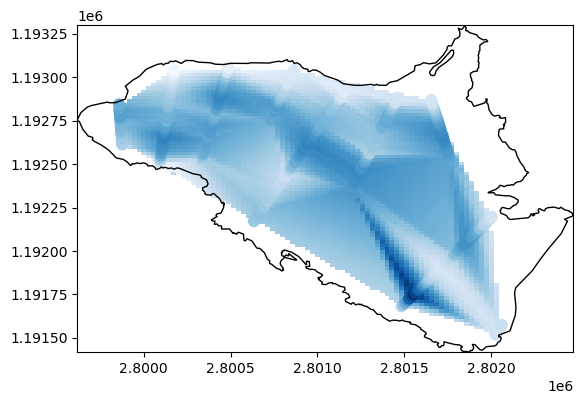

In [31]:
f, ax = plt.subplots()
#using imshow
ax.imshow(grid_z.T, origin='lower', extent=[grid_x.min(), grid_x.max(), grid_y.min(), grid_y.max()], aspect='auto', cmap='Blues')
#using contour
#ax.contourf(grid_x, grid_y, grid_z, cmap='Blues')

#add points from measurements
d = plt.scatter(
    points_inside.geometry.x,  # x-coordinates of points
    points_inside.geometry.y,  # y-coordinates of points
    c=points_inside['THICKNESS'],  # values to use for coloring
    cmap='Blues',  # colormap
    s=75,  # size of markers
    edgecolor='none',  # edge color of markers
    alpha=1  # transparency
)
outline.plot(ax=ax, facecolor='None')

In [114]:
# Now let's save this dataset as a raster
x, y = np.meshgrid(grid_x, grid_y)

In [147]:
#transform = from_origin(x.min(), y.max(), (x.max()-x.min())/grid_x.shape[1], (y.min()-y.max())/grid_z.shape[0])
pixel_width = (x.max()-x.min())/grid_x.shape[1]
pixel_height = (y.max()-y.min())/grid_z.shape[0]
transform = Affine.translation(x.min(), y.max()) * Affine.scale(pixel_width, -pixel_height)

In [153]:
transform

Affine(28.547000022255816, 0.0, 2799617.8317236,
       0.0, -18.82338000679156, 1193300.259081175)

In [154]:
metadata = {
    'driver': 'GTiff',
    'dtype': 'float32',
    'nodata': -9999,
    'width': grid_z.shape[1],
    'height': grid_z.shape[0],
    'count': 1,
    'crs': 'EPSG:2056',  # Example EPSG code, replace with appropriate CRS
    'transform': transform
}

In [172]:
with rasterio.open('data/glathida_interpolated.tif', 'w', **metadata) as dst:
    dst.write(np.fliplr(grid_z).astype('float64'), 1)


In [173]:
thickness_interpolated = xdem.DEM('data/glathida_interpolated.tif')

In [183]:
thickness_diff = thickness_lv95-thickness_interpolated.reproject(thickness_lv95)

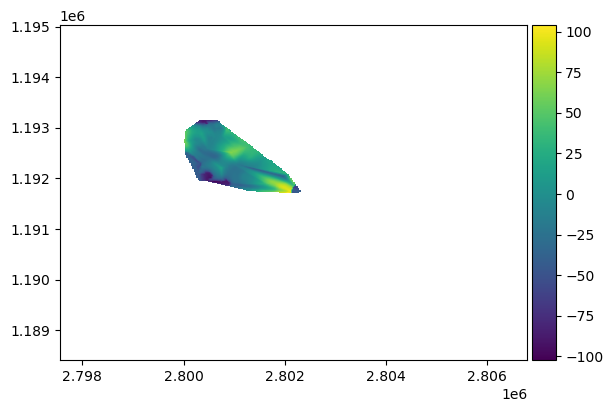

In [185]:
f, ax = plt.subplots()
#thickness_interpolated.plot(ax=ax, zorder=5, alpha=0.8)
#thickness_lv95.plot(ax=ax, zorder=0, alpha=1)
thickness_diff.plot(ax=ax)

In [186]:
thickness_diff

DEM(
  data=[[-- -- -- ... -- -- --]
        [-- -- -- ... -- -- --]
        [-- -- -- ... -- -- --]
        ...
        [-- -- -- ... -- -- --]
        [-- -- -- ... -- -- --]
        [-- -- -- ... -- -- --]]
  transform=| 2.00, 0.00, 2797549.50|
            | 0.00,-2.00, 1195031.00|
            | 0.00, 0.00, 1.00|
  crs=EPSG:2056
  nodata=-9999.0)